# Konnektor - Building Ligand Networks

this is Konnektor, which you can use to construct different types of Networks.

In [1]:
import numpy as np
from rdkit import Chem

try:
    from kartograf import KartografAtomMapper, MappingRMSDScorer
except ModuleNotFoundError:
    !{sys.executable} -m pip install git+https://github.com/OpenFreeEnergy/kartograf.git
    from kartograf import KartografAtomMapper, MappingRMSDScorer


import logging
from kartograf.atom_mapper import logger
logger.setLevel(logging.ERROR)


/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


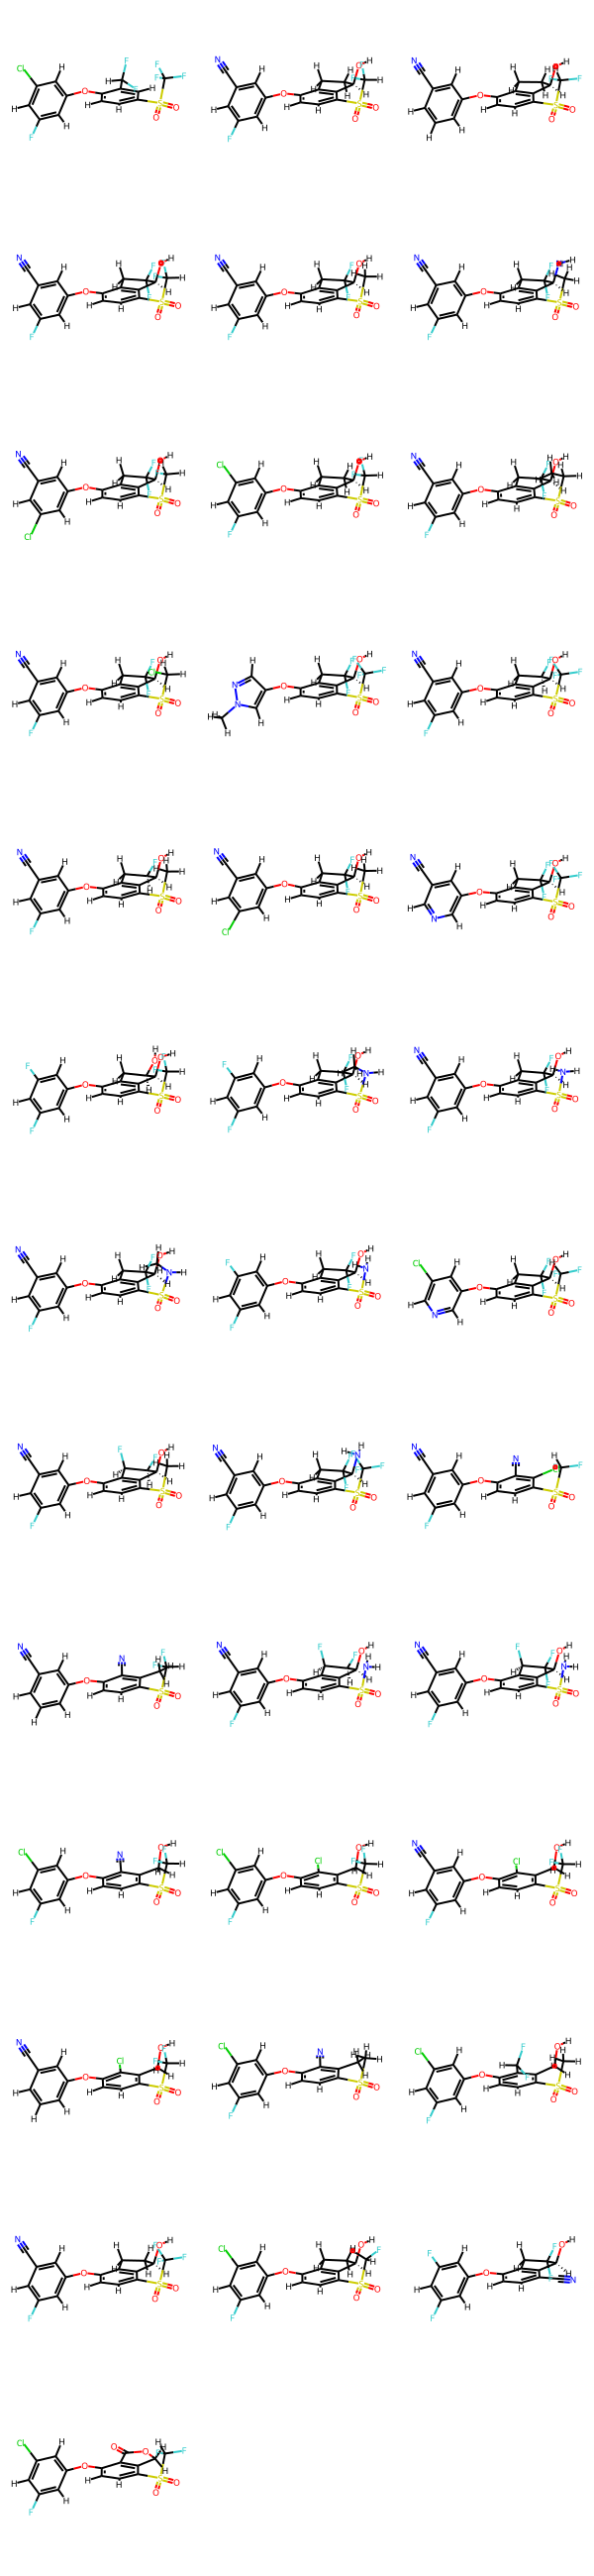

In [2]:
from kartograf import SmallMoleculeComponent
from konnektor.visualization import draw_ligand_network, draw_network_widget

mapper = KartografAtomMapper()
scorer = MappingRMSDScorer()

from konnektor.data import get_hif2a_ligands
compounds = get_hif2a_ligands()
#rdmols = list(Chem.SDMolSupplier(benzenes_sdf_path, removeHs=False))
#compounds = [SmallMoleculeComponent.from_rdkit(m) for m in rdmols]
#compounds = list(filter(lambda x: not x.name in ["lig_2", "lig_3", "lig_4", "lig_7"], compounds))
Chem.Draw.MolsToGridImage ([c.to_rdkit() for c in compounds], )

# Radial Network Layout

In [3]:
from konnektor.network_planners import StarNetworkGenerator
ligand_network_planner = StarNetworkGenerator(mapper=KartografAtomMapper(), scorer=scorer)

In [4]:
radial_network = ligand_network_planner(compounds)
radial_network.name="Star Network"
radial_network

<LigandNetwork-87be50120f3406c58c52909e523ef490>

In [5]:
draw_network_widget(radial_network);

interactive(children=(Dropdown(description='layout', index=6, options=('dagre', 'cola', 'breadthfirst', 'circu…

S## Starry Sky Network Layout

In [6]:
from konnektor.network_planners import StarrySkyNetworkGenerator
# Clustering
from scikit_mol.fingerprints import RDKitFingerprintTransformer, MorganFingerprintTransformer
from sklearn.cluster import HDBSCAN, OPTICS
from konnektor.network_tools.cluster_components import ComponentsDiversityClustering
ligand_network_planner = StarrySkyNetworkGenerator(mapper=KartografAtomMapper(), 
                                                       scorer=scorer)

In [7]:
starry_sky_network = ligand_network_planner(compounds)
starry_sky_network.name="Starry Sky Network"
starry_sky_network

<LigandNetwork-1b6e866b545e57a0d0605c6175d36552>

In [8]:
draw_network_widget(starry_sky_network);

interactive(children=(Dropdown(description='layout', index=6, options=('dagre', 'cola', 'breadthfirst', 'circu…

# Minimal Spanning Tree

In [9]:
from konnektor.network_planners import MinimalSpanningTreeNetworkGenerator

ligand_network_planner = MinimalSpanningTreeNetworkGenerator(mapper=KartografAtomMapper(), scorer=scorer)


In [10]:
mst_network = ligand_network_planner(compounds)
mst_network.name="Min Spanning Tree Network"
mst_network

<LigandNetwork-3af39eafd0d98450bb2174db6c02d5a0>

In [11]:
draw_network_widget(mst_network, layout="breadthfirst");

interactive(children=(Dropdown(description='layout', index=2, options=('dagre', 'cola', 'breadthfirst', 'circu…

# Redundant MST

In [12]:
from konnektor.network_planners import RedundantMinimalSpanningTreeNetworkGenerator

ligand_network_planner = (RedundantMinimalSpanningTreeNetworkGenerator
                          (mapper=KartografAtomMapper(), scorer=scorer,
                           n_redundancy=2))


In [13]:
rmst_network = ligand_network_planner(compounds)
rmst_network.name="Redundant Min Spanning Tree Network"
rmst_network

<LigandNetwork-7b7842c9157e9f6b67f13b5f1d191980>

In [14]:
draw_network_widget(rmst_network);

interactive(children=(Dropdown(description='layout', index=6, options=('dagre', 'cola', 'breadthfirst', 'circu…

# Cyclo Graphs

In [15]:
from konnektor.network_planners import CyclicNetworkGenerator
ligand_network_planner = CyclicNetworkGenerator(mapper=KartografAtomMapper(), scorer=scorer,
                                                    cycle_sizes=3, node_present_in_cycles=2)

In [16]:
cyclic_network = ligand_network_planner.generate_ligand_network(compounds)
cyclic_network.name="Cyclic Network"
cyclic_network

<LigandNetwork-954129b477e39defbe69f93835ffb72a>

In [17]:
draw_network_widget(cyclic_network);

interactive(children=(Dropdown(description='layout', index=6, options=('dagre', 'cola', 'breadthfirst', 'circu…

# Maximally connected network

In [18]:
import logging
from konnektor.network_planners import MaximalNetworkGenerator
from kartograf.atom_mapper import logger
logger.setLevel(logging.ERROR)

ligand_network_planner = MaximalNetworkGenerator(mapper=KartografAtomMapper(), scorer=scorer)
ligand_network_planner.nprocesses = 3


In [19]:
len(compounds)*len(compounds)//2

684

In [20]:
max_network = ligand_network_planner(compounds)
max_network.name = "Maximal Network"
max_network

<LigandNetwork-aa99334f306280b21c7e5de96b04ff70>

In [21]:
draw_network_widget(max_network, layout="concentric");

interactive(children=(Dropdown(description='layout', index=5, options=('dagre', 'cola', 'breadthfirst', 'circu…

# Diversity Cluster Network

In [22]:
from konnektor.network_planners import TwoDimensionalNetworkGenerator
ligand_network_planner = TwoDimensionalNetworkGenerator(mapper=KartografAtomMapper(), scorer=scorer)

In [ ]:
div_network = ligand_network_planner(compounds)
div_network.name = "Diversity Clustering Network"
div_network

In [ ]:
draw_network_widget(div_network, layout="dagre");

# Summary

In [ ]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=[9*4,2*9])
axes= np.array(axes).flat

fs = 22
for ax, net in zip(axes, [radial_network, starry_sky_network, 
                          mst_network, rmst_network,
                          cyclic_network, div_network,
                          max_network]):
    draw_ligand_network(network=net, title=net.name, ax=ax, node_size=1500)
    ax.axis("off")
axes[-1].axis("off")



In [ ]:
fig.savefig("../.img/network_layouts.png", dpi=400)